In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

# Load data
df = pd.read_csv("/content/aapl.us.txt", parse_dates=["Date"])
df = df.sort_values("Date").reset_index(drop=True)


In [8]:
# Daily Return
df["Daily Return"] = df["Close"].pct_change()

# Moving Averages
df["7D MA"] = df["Close"].rolling(window=7).mean()
df["30D MA"] = df["Close"].rolling(window=30).mean()

# 30-Day Volatility
df["30D Volatility"] = df["Daily Return"].rolling(window=30).std()

# RSI Calculation
delta = df["Close"].diff()
gain = delta.clip(lower=0).rolling(window=14).mean()
loss = -delta.clip(upper=0).rolling(window=14).mean()
rs = gain / loss
df["RSI"] = 100 - (100 / (1 + rs))

# Drop NaNs
df = df.dropna().reset_index(drop=True)


In [9]:
split = int(len(df) * 0.8)
train_df = df.iloc[:split]
test_df = df.iloc[split:]


In [10]:
# Create lag features
for i in range(1, 6):
    df[f'lag_{i}'] = df['Close'].shift(i)

df = df.dropna().reset_index(drop=True)

X_lr = df[[f'lag_{i}' for i in range(1, 6)]]
y_lr = df['Close']

X_train_lr = X_lr.iloc[:split]
y_train_lr = y_lr.iloc[:split]
X_test_lr = X_lr.iloc[split:]
y_test_lr = y_lr.iloc[split:]

lr_model = LinearRegression()
lr_model.fit(X_train_lr, y_train_lr)
pred_lr = lr_model.predict(X_test_lr)


In [11]:
arima_model = ARIMA(train_df["Close"], order=(5, 1, 0))
arima_result = arima_model.fit()
pred_arima = arima_result.forecast(steps=len(test_df))


In [12]:
features = ["7D MA", "30D MA", "RSI", "30D Volatility"]
rf_df = df.dropna().reset_index(drop=True)

X_rf = rf_df[features]
y_rf = rf_df["Close"]

X_train_rf = X_rf.iloc[:split]
y_train_rf = y_rf.iloc[:split]
X_test_rf = X_rf.iloc[split:]
y_test_rf = y_rf.iloc[split:]

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_rf, y_train_rf)
pred_rf = rf_model.predict(X_test_rf)


In [13]:
def directional_accuracy(y_true, y_pred):
    return np.mean(np.sign(np.diff(y_true)) == np.sign(np.diff(y_pred)))

mae_lr = mean_absolute_error(y_test_lr, pred_lr)
mae_arima = mean_absolute_error(test_df["Close"], pred_arima)
mae_rf = mean_absolute_error(y_test_rf, pred_rf)

acc_lr = directional_accuracy(y_test_lr.values, pred_lr)
acc_arima = directional_accuracy(test_df["Close"].values, pred_arima)
acc_rf = directional_accuracy(y_test_rf.values, pred_rf)

print("Linear Regression: MAE =", mae_lr, ", Directional Acc =", acc_lr)
print("ARIMA: MAE =", mae_arima, ", Directional Acc =", acc_arima)
print("Random Forest: MAE =", mae_rf, ", Directional Acc =", acc_rf)


Linear Regression: MAE = 0.9817415917330164 , Directional Acc = 0.4990969295605057
ARIMA: MAE = 46.206928479937766 , Directional Acc = 0.014405762304921969
Random Forest: MAE = 46.11661348375453 , Directional Acc = 0.5201685731487056


In [14]:
signal = np.where(pred_lr > y_test_lr.values, 1, -1)
returns = test_df["Daily Return"].iloc[:len(signal)].values
strategy_returns = signal[:-1] * returns[1:]

# Sharpe Ratio
sharpe = np.mean(strategy_returns) / np.std(strategy_returns) * np.sqrt(252)

# Turnover
turnover = np.sum(np.abs(np.diff(signal))) / len(signal)

print("Backtest - Sharpe Ratio:", sharpe)
print("Backtest - Turnover:", turnover)


Backtest - Sharpe Ratio: -0.11290588163802157
Backtest - Turnover: 1.0060168471720818


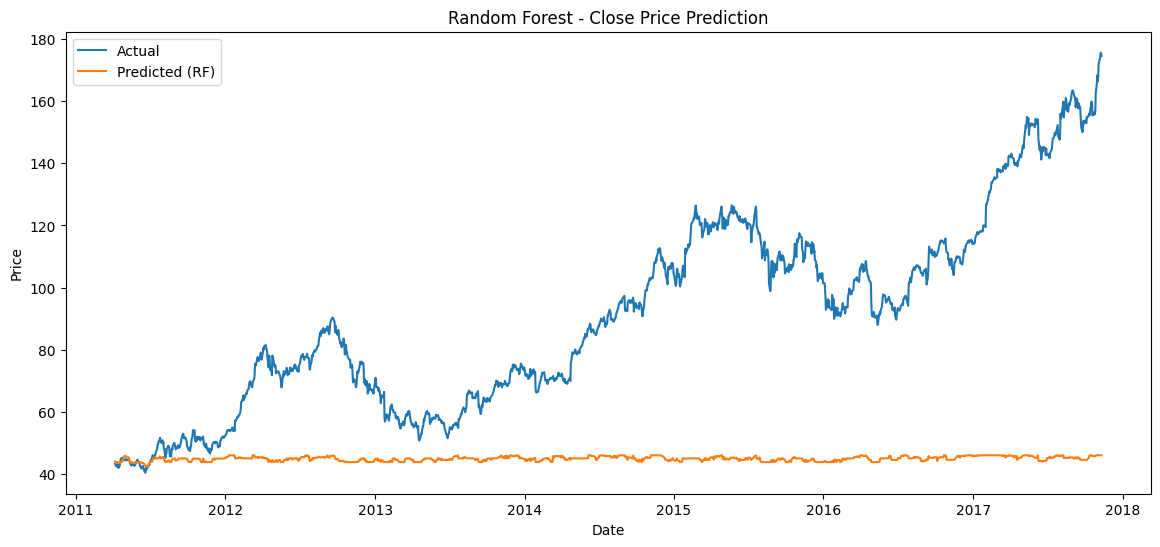

In [15]:
plt.figure(figsize=(14,6))
# Use the 'Date' column from rf_df which aligns with y_test_rf
plt.plot(rf_df["Date"].iloc[split:], y_test_rf.values, label="Actual")
plt.plot(rf_df["Date"].iloc[split:], pred_rf, label="Predicted (RF)") # Also update the date for predicted values
plt.title("Random Forest - Close Price Prediction")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

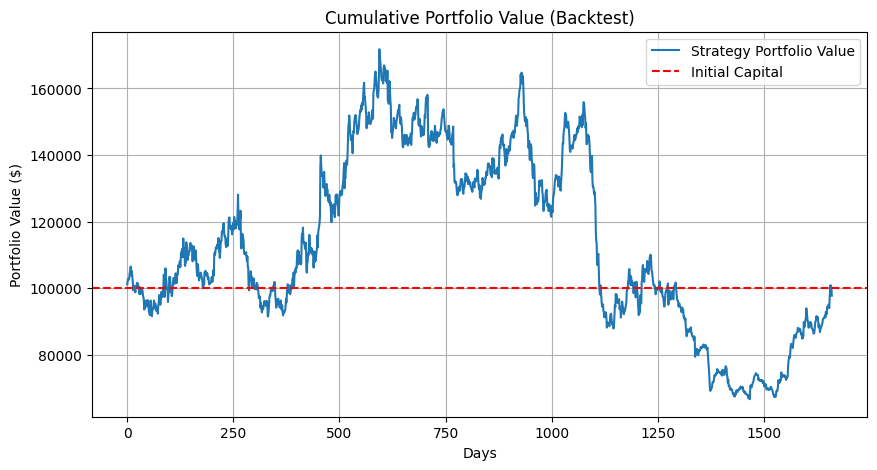

Initial Capital: $100,000.00
Final Portfolio Value: $97,721.07
Total Profit/Loss: $-2,278.93


In [16]:
# Initial capital
initial_capital = 100000

# Align lengths
test_close = y_test_lr.values[:len(pred_lr)]
pred_close = pred_lr

# Generate trading signals: 1 for Buy, -1 for Sell
signal = np.where(pred_close > test_close, -1, 1)

# Daily return from test set (aligned properly)
returns = test_df["Daily Return"].iloc[:len(signal)].values

# Strategy return = signal * daily return
strategy_returns = signal[:-1] * returns[1:]  # shift one day ahead

# Cumulative return over test period
cumulative_return = np.cumprod(1 + strategy_returns)

# Final portfolio value
final_value = initial_capital * cumulative_return[-1]
total_profit = final_value - initial_capital

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(cumulative_return * initial_capital, label="Strategy Portfolio Value")
plt.axhline(initial_capital, color="red", linestyle="--", label="Initial Capital")
plt.title("Cumulative Portfolio Value (Backtest)")
plt.xlabel("Days")
plt.ylabel("Portfolio Value ($)")
plt.legend()
plt.grid(True)
plt.show()

# Output result
print(f"Initial Capital: ${initial_capital:,.2f}")
print(f"Final Portfolio Value: ${final_value:,.2f}")
print(f"Total Profit/Loss: ${total_profit:,.2f}")


In [17]:
# Rate of Change (ROC)
df["ROC"] = df["Close"].pct_change(periods=5)

# Momentum: Price - Price_n_days_ago
df["Momentum_10"] = df["Close"] - df["Close"].shift(10)

# MACD
ema_12 = df["Close"].ewm(span=12, adjust=False).mean()
ema_26 = df["Close"].ewm(span=26, adjust=False).mean()
df["MACD"] = ema_12 - ema_26
df["MACD_Signal"] = df["MACD"].ewm(span=9, adjust=False).mean()

# Z-score of mean reversion (vs 30-day MA)
df["Z_score_30"] = (df["Close"] - df["30D MA"]) / df["30D Volatility"]

# Bollinger Band Width
df["BB_upper"] = df["30D MA"] + 2 * df["30D Volatility"]
df["BB_lower"] = df["30D MA"] - 2 * df["30D Volatility"]
df["BB_width"] = df["BB_upper"] - df["BB_lower"]

# Clean up
df = df.dropna().reset_index(drop=True)


In [18]:
# Update features list
features = [
    "7D MA", "30D MA", "RSI", "30D Volatility",
    "ROC", "Momentum_10", "MACD", "MACD_Signal",
    "Z_score_30", "BB_width"
]

# Prepare data
X_rf = df[features]
y_rf = df["Close"]

X_train_rf = X_rf.iloc[:split]
y_train_rf = y_rf.iloc[:split]
X_test_rf = X_rf.iloc[split:]
y_test_rf = y_rf.iloc[split:]

# Re-train Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_rf, y_train_rf)
pred_rf = rf_model.predict(X_test_rf)


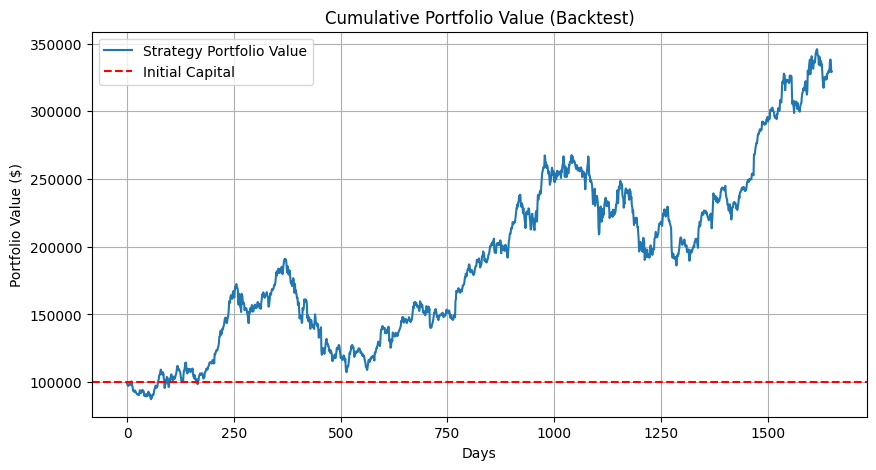

Initial Capital: $100,000.00
Final Portfolio Value: $329,428.00
Total Profit/Loss: $229,428.00


In [19]:
# Initial capital
initial_capital = 100000

# Align lengths
test_close = y_test_rf.values
pred_close = pred_rf

# Generate trading signals: 1 for Buy, -1 for Sell
signal = np.where(pred_close > test_close, -1, 1)

# Daily return from test set (aligned properly)
returns = test_df["Daily Return"].iloc[:len(signal)].values

# Strategy return = signal * daily return
strategy_returns = signal[:-1] * returns[1:]  # shift one day ahead

# Cumulative return over test period
cumulative_return = np.cumprod(1 + strategy_returns)

# Final portfolio value
final_value = initial_capital * cumulative_return[-1]
total_profit = final_value - initial_capital

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(cumulative_return * initial_capital, label="Strategy Portfolio Value")
plt.axhline(initial_capital, color="red", linestyle="--", label="Initial Capital")
plt.title("Cumulative Portfolio Value (Backtest)")
plt.xlabel("Days")
plt.ylabel("Portfolio Value ($)")
plt.legend()
plt.grid(True)
plt.show()

# Output result
print(f"Initial Capital: ${initial_capital:,.2f}")
print(f"Final Portfolio Value: ${final_value:,.2f}")
print(f"Total Profit/Loss: ${total_profit:,.2f}")


In [20]:
lr_model = LinearRegression()
lr_model.fit(X_train_rf, y_train_rf)
pred_lr = lr_model.predict(X_test_rf)

# Evaluation
mae_lr = mean_absolute_error(y_test_rf, pred_lr)
print("Linear Regression MAE:", mae_lr)

Linear Regression MAE: 0.7132033314422369


In [21]:
import lightgbm as lgb

# LightGBM Regressor
lgbm_model = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.05, random_state=42)
lgbm_model.fit(X_train_rf, y_train_rf)
pred_lgbm = lgbm_model.predict(X_test_rf)

# Evaluation
mae_lgbm = mean_absolute_error(y_test_rf, pred_lgbm)
print("LightGBM MAE:", mae_lgbm)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000972 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 6667, number of used features: 10
[LightGBM] [Info] Start training from score 5.339078
LightGBM MAE: 46.57743756909982


In [22]:
def directional_accuracy(y_true, y_pred):
    return np.mean(np.sign(np.diff(y_true)) == np.sign(np.diff(y_pred)))

acc_lr = directional_accuracy(y_test_rf.values, pred_lr)
acc_lgbm = directional_accuracy(y_test_rf.values, pred_lgbm)

print("Linear Regression Directional Accuracy:", acc_lr)
print("LightGBM Directional Accuracy:", acc_lgbm)


Linear Regression Directional Accuracy: 0.8437310720775287
LightGBM Directional Accuracy: 0.628709872804361


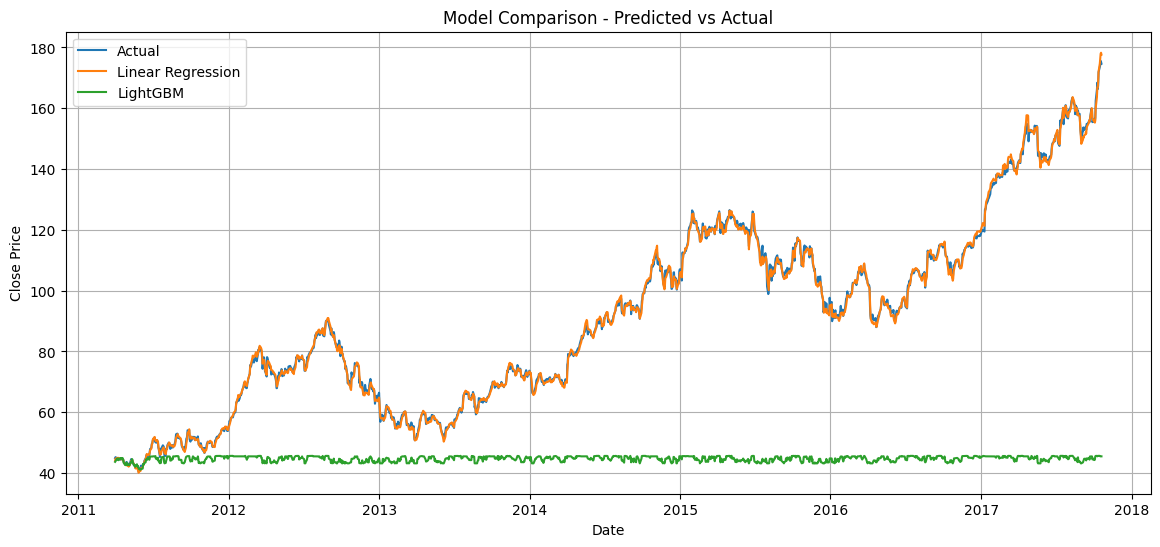

In [23]:
plt.figure(figsize=(14,6))
plt.plot(test_df["Date"].iloc[:len(pred_lgbm)], y_test_rf.values, label="Actual")
plt.plot(test_df["Date"].iloc[:len(pred_lgbm)], pred_lr, label="Linear Regression")
plt.plot(test_df["Date"].iloc[:len(pred_lgbm)], pred_lgbm, label="LightGBM")
plt.title("Model Comparison - Predicted vs Actual")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.show()


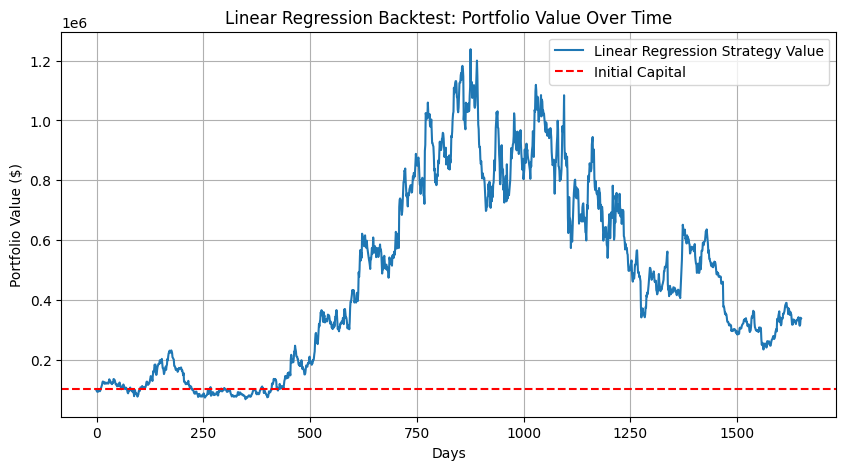

Initial Capital: $100,000.00
Final Portfolio Value: $338,081.79
Total Profit/Loss: $238,081.79


In [24]:
# Initial capital
initial_capital = 100000

# Trading signals: Buy (1) if predicted > actual, else Sell (-1)
signal_lr = np.where(pred_lr > y_test_rf.values, -3, 3)

# Align daily returns for backtesting
returns_lr = test_df["Daily Return"].iloc[:len(signal_lr)].values

# Strategy returns: next day return × current signal
strategy_returns_lr = signal_lr[:-1] * returns_lr[1:]

# Cumulative returns
cumulative_return_lr = np.cumprod(1 + strategy_returns_lr)

# Final portfolio value and profit
final_value_lr = initial_capital * cumulative_return_lr[-1]
total_profit_lr = final_value_lr - initial_capital

# Plot
plt.figure(figsize=(10, 5))
plt.plot(cumulative_return_lr * initial_capital, label="Linear Regression Strategy Value")
plt.axhline(initial_capital, color="red", linestyle="--", label="Initial Capital")
plt.title("Linear Regression Backtest: Portfolio Value Over Time")
plt.xlabel("Days")
plt.ylabel("Portfolio Value ($)")
plt.legend()
plt.grid(True)
plt.show()

# Output
print(f"Initial Capital: ${initial_capital:,.2f}")
print(f"Final Portfolio Value: ${final_value_lr:,.2f}")
print(f"Total Profit/Loss: ${total_profit_lr:,.2f}")


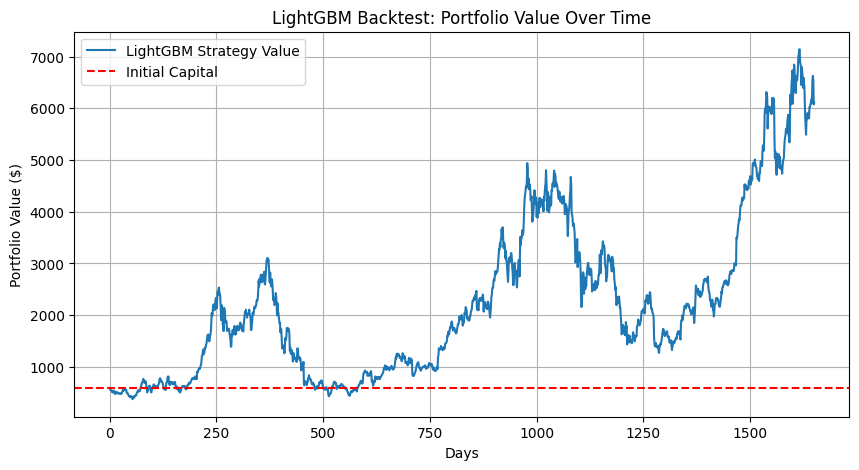

Initial Capital: $600.00
Final Portfolio Value: $6,106.84
Total Profit/Loss: $5,506.84


In [34]:
# Initial capital
initial_capital = 600

# Trading signals: Buy (1) if predicted > actual, else Sell (-1)
signal_lgbm = np.where(pred_lgbm > y_test_rf.values, -3, 3)

# Align daily returns for strategy
returns_lgbm = test_df["Daily Return"].iloc[:len(signal_lgbm)].values

# Strategy returns: signal_t × return_{t+1}
strategy_returns_lgbm = signal_lgbm[:-1] * returns_lgbm[1:]

# Cumulative return
cumulative_return_lgbm = np.cumprod(1 + strategy_returns_lgbm)

# Final portfolio value
final_value_lgbm = initial_capital * cumulative_return_lgbm[-1]
total_profit_lgbm = final_value_lgbm - initial_capital

# Plot
plt.figure(figsize=(10, 5))
plt.plot(cumulative_return_lgbm * initial_capital, label="LightGBM Strategy Value")
plt.axhline(initial_capital, color="red", linestyle="--", label="Initial Capital")
plt.title("LightGBM Backtest: Portfolio Value Over Time")
plt.xlabel("Days")
plt.ylabel("Portfolio Value ($)")
plt.legend()
plt.grid(True)
plt.show()

# Output
print(f"Initial Capital: ${initial_capital:,.2f}")
print(f"Final Portfolio Value: ${final_value_lgbm:,.2f}")
print(f"Total Profit/Loss: ${total_profit_lgbm:,.2f}")


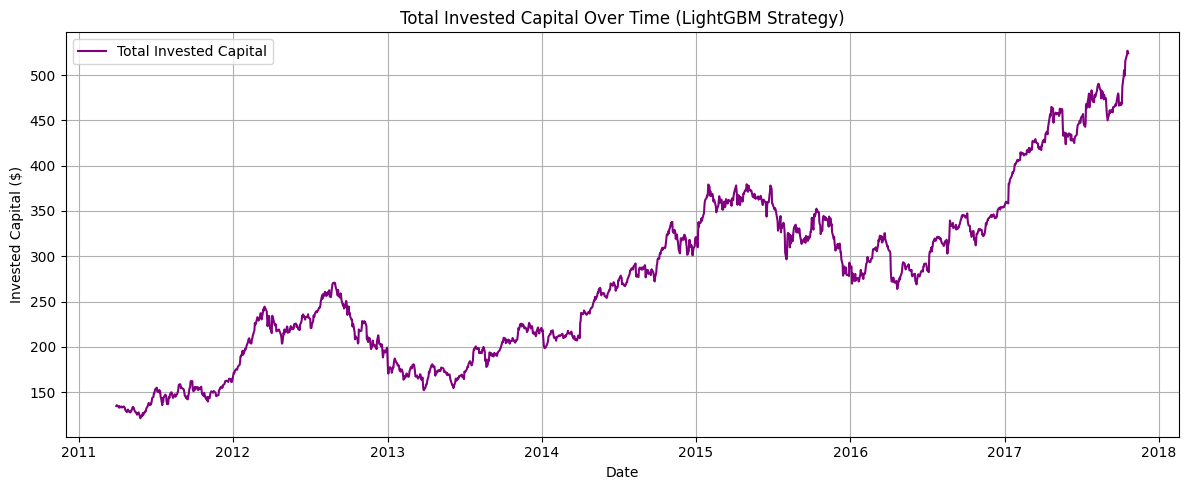

In [33]:
# Recalculate signal and align
signal_lgbm = np.where(pred_lgbm > y_test_rf.values, -3, 3)
dates = test_df["Date"].iloc[:len(signal_lgbm)]

# Price series aligned
price_series = y_test_rf.values[:len(signal_lgbm)]

# Absolute value of position × price = invested capital
invested_capital = np.abs(signal_lgbm) * price_series

# Plot
plt.figure(figsize=(12, 5))
plt.plot(dates, invested_capital, color='purple', label='Total Invested Capital')
plt.title("Total Invested Capital Over Time (LightGBM Strategy)")
plt.xlabel("Date")
plt.ylabel("Invested Capital ($)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


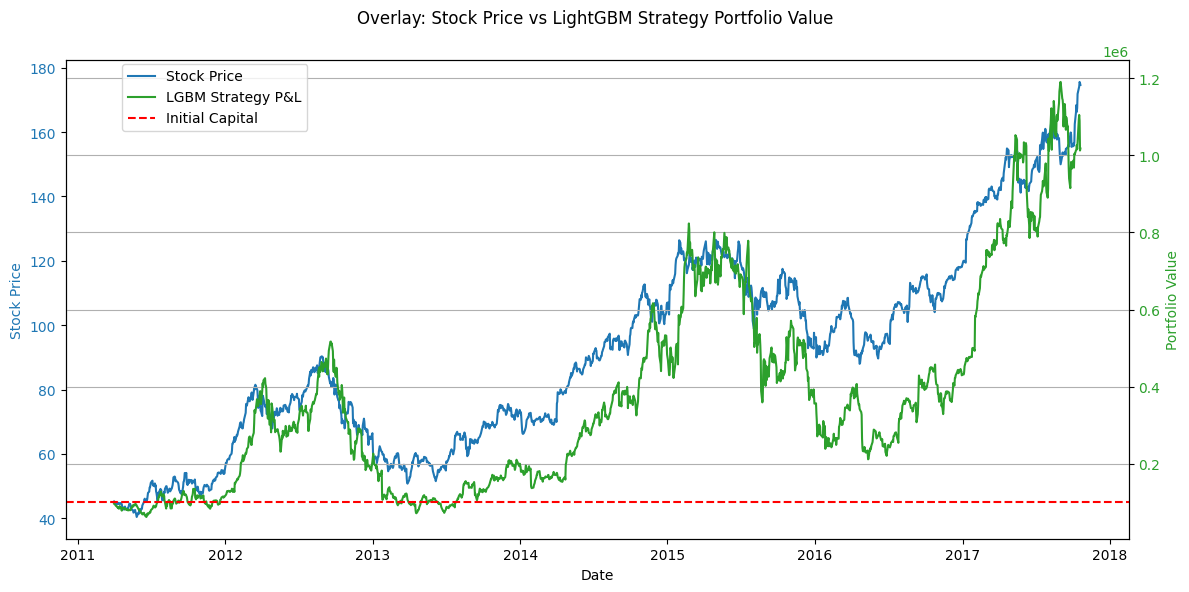

In [26]:


# Ensure date is datetime format
test_df["Date"] = pd.to_datetime(test_df["Date"])

# Align data lengths
dates = test_df["Date"].iloc[1:len(strategy_returns_lgbm)+1]
price_plot = y_test_rf.values[1:len(strategy_returns_lgbm)+1]
portfolio_value = cumulative_return_lgbm * initial_capital

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot stock price (left y-axis)
color_price = 'tab:blue'
ax1.set_xlabel("Date")
ax1.set_ylabel("Stock Price", color=color_price)
ax1.plot(dates, price_plot, color=color_price, label="Stock Price")
ax1.tick_params(axis='y', labelcolor=color_price)

# Create second y-axis for portfolio value
ax2 = ax1.twinx()
color_pnl = 'tab:green'
ax2.set_ylabel("Portfolio Value", color=color_pnl)
ax2.plot(dates, portfolio_value, color=color_pnl, label="LGBM Strategy P&L")
ax2.axhline(initial_capital, color="red", linestyle="--", label="Initial Capital")
ax2.tick_params(axis='y', labelcolor=color_pnl)

# Legends and layout
fig.suptitle("Overlay: Stock Price vs LightGBM Strategy Portfolio Value")
fig.tight_layout()
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))
plt.grid(True)
plt.show()
